In [1]:
%matplotlib inline

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

In [2]:
import time
import pickle
from itertools import combinations_with_replacement

import numpy as np
import matplotlib.pyplot as plt

import fitsio
import tensorflow as tf

/Users/dforeman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
labels_base = fitsio.read("data_from_andy/apogee-dr14-giants.fits")

pkl_kwds = dict(encoding="latin-1")
with open("data_from_andy/apogee-dr14-giants-flux-ivar.pkl", "rb") as fp:
    flux, ivar = pickle.load(fp, **pkl_kwds)
    
# s = slice(500, 1550)
s = slice(None)
flux = flux[:, s]
ivar = ivar[:, s]
    
label_names = ["TEFF", "LOGG", "FE_H"]
labels = np.concatenate(
    [labels_base[n][:, None].astype(float) for n in label_names],
axis=1)
label_errs = np.concatenate(
    [labels_base[n+"_ERR"][:, None].astype(float) for n in label_names],
axis=1)

print(labels.shape, flux.shape)

m_train = np.random.rand(len(labels)) < 0.8
m_test = ~m_train
print(m_train.sum(), m_test.sum())

train_labels = labels[m_train]
train_label_ivar = 1.0 / label_errs[m_train]**2
train_flux = flux[m_train]
train_ivar = ivar[m_train]
test_labels = labels[m_test]
test_flux = flux[m_test]
test_ivar = ivar[m_test]

mu = np.mean(train_labels, axis=0)
std = np.std(train_labels, axis=0)

(1624, 3) (1624, 8575)
1265 359


In [4]:
def get_design(A, mu, std, order=2):
    A_norm = (A - mu) / std
    blocks = [np.ones((len(A), 1))]
    for order in range(1, order + 1):
        for inds in combinations_with_replacement(range(A_norm.shape[1]), order):
            blocks.append(np.product(A_norm[:, inds], axis=1)[:, None])
    return np.concatenate(blocks, axis=1)

In [5]:
order = 2
D = get_design(train_labels, mu, std, order=order)
weights = np.empty((D.shape[1], train_flux.shape[1]))
for n in range(train_flux.shape[1]):
    weights[:, n] = np.linalg.solve(np.dot(D.T, D * train_ivar[:, n][:, None]), np.dot(D.T, train_ivar[:, n]*train_flux[:, n]))

In [6]:
weights.shape

(10, 8575)

In [7]:
learning_rate = 0.01
n_star, n_pix = train_flux.shape
n_labels = train_labels.shape[1]

In [8]:
F = tf.convert_to_tensor(train_flux, dtype=tf.float32)
F_ivar = tf.convert_to_tensor(train_ivar, dtype=tf.float32) 
L = tf.convert_to_tensor(train_labels, dtype=tf.float32)
L_ivar = tf.convert_to_tensor(train_label_ivar, dtype=tf.float32)

In [9]:
# A_norm = (train_labels - mu) / std
As = [tf.Variable(tf.convert_to_tensor((train_labels[:, i:i+1] - mu[i]) / std[i], dtype=tf.float32),
                  name="A_{0}".format(i))
      for i in range(n_labels)]
Ws = [tf.Variable(tf.convert_to_tensor(weights[i:i+1], dtype=tf.float32),
                  name="W_{0}".format(i))
      for i in range(len(weights))]

j = 1
F_ = tf.matmul(tf.ones((n_star, 1), dtype=tf.float32), Ws[0])
for o in range(1, order + 1):
    for inds in combinations_with_replacement(range(n_labels), o):
        m = tf.ones((n_star, 1), dtype=tf.float32)
        for i in inds:
            m = tf.multiply(m, As[i])
        F_ += tf.matmul(m, Ws[j])
        j += 1

In [10]:
log_jitter = tf.Variable(-8.0 + tf.zeros((n_star, 1)), name="log_jitter")

In [11]:
ivar = 1.0 / (1.0 / F_ivar + tf.exp(log_jitter))
cost = tf.reduce_sum(tf.multiply(tf.square(F_ - F), ivar))
cost -= tf.reduce_sum(tf.log(ivar))
for i in range(n_labels):
    cost += tf.reduce_sum(tf.multiply(tf.square(As[i][:, 0] * std[i] + mu[i] - L[:, i]), L_ivar[:, i]))
cost /= n_star * n_pix
var_grad = tf.gradients(cost, As + Ws)

# training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost, var_list=Ws)
training_step = tf.train.AdamOptimizer().minimize(cost, var_list=Ws + As + [log_jitter])

In [12]:
init = tf.global_variables_initializer()

In [21]:
import tqdm
cost_hist = []
with tf.Session() as sess:
    r1 = sess.run(init)

#     result = sess.run(cost)
#     r1 = sess.run(init)
#     print(r1)
#     print(sess.run(var_grad))
    for i in tqdm.trange(2000):
        sess.run(training_step)
        cost_hist.append(sess.run(cost))
        
    W_res = sess.run(Ws)
    A_res = sess.run(As)
    F_res = sess.run(F_)
    log_jitter_res = sess.run(log_jitter)

100%|██████████| 2000/2000 [16:55<00:00,  2.03it/s]


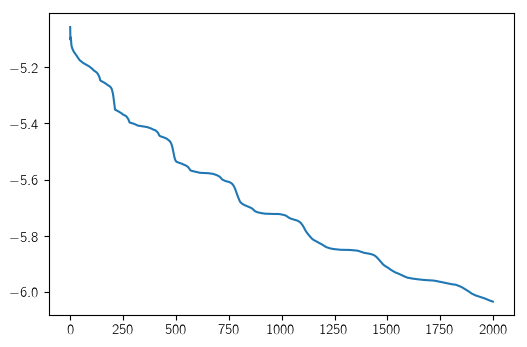

In [22]:
plt.plot(cost_hist)

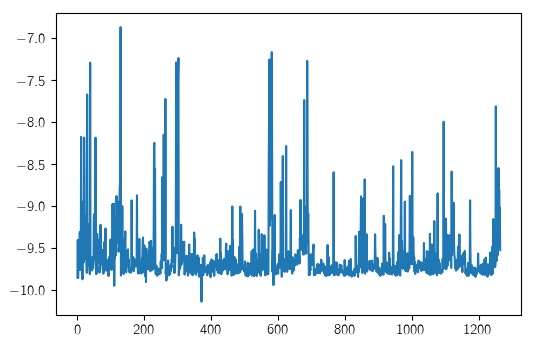

In [23]:
plt.plot(log_jitter_res[:, 0])

23267173.8689
43444875.6012


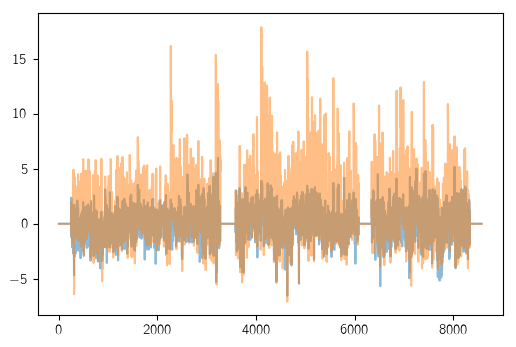

In [24]:
i = 0
plt.plot((train_flux[i] - F_res[i]) * np.sqrt(train_ivar[i]), alpha=0.5)
plt.plot((train_flux[i] - np.dot(D[i], weights)) * np.sqrt(train_ivar[i]), alpha=0.5)
print(np.sum((train_flux - F_res)**2 * train_ivar))
print(np.sum((train_flux - np.dot(D, weights))**2 * train_ivar))

<Container object of 3 artists>

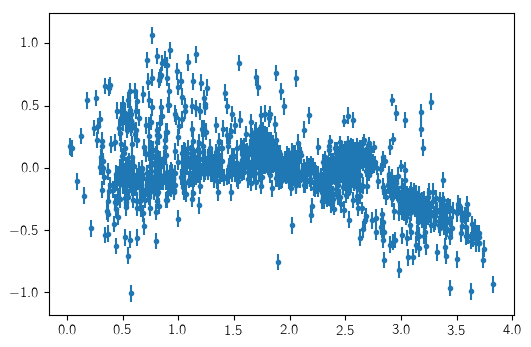

In [27]:
ind = 1
pred = A_res[ind][:, 0] * std[ind] + mu[ind]
plt.errorbar(train_labels[:, ind], pred - train_labels[:, ind],
             yerr=1.0/np.sqrt(train_label_ivar[:, ind]),
             fmt=".", capsize=0)

In [92]:
A_0 = tf.ones((n_star, 1), dtype=tf.float32)
W_0 = tf.convert_to_tensor(weights[:1], dtype=tf.float32)

A_1 = A
W_1 = tf.convert_to_tensor(weights[1:1+n_labels], dtype=tf.float32)

A_2 = tf.multiply(A, A)
W_2 = tf.convert_to_tensor(weights[1+n_labels:1+2*n_labels], dtype=tf.float32)

f_ = tf.matmul(A_0, W_0) + tf.matmul(A_1, W_1) + tf.matmul(A_2, W_2)
cost = tf.reduce_sum(tf.multiply(tf.square(f_ - F), F_ivar))
cost += tf.reduce_sum(tf.multiply(tf.square(A - L), L_ivar))
var_grad = tf.gradients(cost, [W_0, W_1, W_2, A_1])

training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [93]:
with tf.Session() as sess:
    r1 = A.initializer.run()
    print(r1)
    result = sess.run(var_grad)

None


In [94]:
[r.shape for r in result]

[(1, 1050), (3, 1050), (3, 1050), (1301, 3)]

In [95]:
result

[array([[-2.72045898,  2.1583252 ,  3.0390625 , ...,  1.76464844,
         -2.42089844, -1.13183594]], dtype=float32),
 array([[ 0.24707031, -0.08007812, -0.17480469, ...,  0.1328125 ,
          0.14453125,  0.18554688],
        [ 0.18164062, -0.04785156, -0.15039062, ...,  0.03125   ,
          0.1953125 ,  0.1640625 ],
        [-0.1138916 ,  0.16540527,  0.21899414, ...,  0.05664062,
         -0.08007812,  0.01269531]], dtype=float32),
 array([[-2.81152344,  2.18164062,  3.10546875, ...,  1.71875   ,
         -2.5703125 , -1.21484375],
        [-2.91210938,  2.00390625,  3.0859375 , ...,  1.671875  ,
         -2.4765625 , -1.078125  ],
        [-2.5569458 ,  1.95178223,  2.93310547, ...,  1.54980469,
         -2.28125   , -1.29199219]], dtype=float32),
 array([[ 52831.6875    ,  20636.59960938,  -7519.14257812],
        [-20789.14453125,   2621.80126953,   6067.38232422],
        [-19653.91796875,   5147.72363281,   7659.609375  ],
        ..., 
        [  8404.35839844,  -2620.01123